## MDSS SCAN ON AUTOSTRAT MODE 

Import the MDSS module and Bernoulli modules

In [1]:
import pandas as pd

import warnings
from pandas.api.types import is_numeric_dtype

warnings.filterwarnings('ignore')

### Data

In [2]:
compas = pd.read_csv('../datasets/compas-scores-two-years-violent.csv')
cols = ['sex', 'age_cat', 'race', 'juv_fel_count', 'juv_misd_count', 'juv_other_count', 'priors_count', 'c_charge_degree', 'v_decile_score']
compas = compas[cols]
compas

,sex,age_cat,race,juv_fel_count,juv_misd_count,juv_other_count,priors_count,c_charge_degree,v_decile_score
0,Male,Greater than 45,Other,0,0,0,0,F,1
1,Male,25 - 45,African-American,0,0,0,0,F,1
2,Male,Less than 25,African-American,0,1,0,1,F,6
3,Male,25 - 45,Other,0,0,0,2,F,1
4,Male,25 - 45,Other,0,0,0,0,M,1
...,...,...,...,...,...,...,...,...,...
4738,Male,Less than 25,African-American,0,0,0,0,F,9
4739,Male,Less than 25,African-American,0,0,0,0,F,5
4740,Male,Less than 25,African-American,0,0,0,0,F,5
4741,Male,Greater than 45,Other,0,0,0,0,F,1


In [3]:
compas.columns

Index(['sex', 'age_cat', 'race', 'juv_fel_count', 'juv_misd_count',
       'juv_other_count', 'priors_count', 'c_charge_degree', 'v_decile_score'],
      dtype='object')

In [4]:
numeric_cols = [col for col in compas.columns if 'count' in col]
numeric_cols

['juv_fel_count', 'juv_misd_count', 'juv_other_count', 'priors_count']

In [5]:
compas.head()

,sex,age_cat,race,juv_fel_count,juv_misd_count,juv_other_count,priors_count,c_charge_degree,v_decile_score
0,Male,Greater than 45,Other,0,0,0,0,F,1
1,Male,25 - 45,African-American,0,0,0,0,F,1
2,Male,Less than 25,African-American,0,1,0,1,F,6
3,Male,25 - 45,Other,0,0,0,2,F,1
4,Male,25 - 45,Other,0,0,0,0,M,1


In [6]:
compas.shape

(4743, 9)

In [7]:
compas.isna().sum()

sex                0
age_cat            0
race               0
juv_fel_count      0
juv_misd_count     0
juv_other_count    0
priors_count       0
c_charge_degree    0
v_decile_score     0
dtype: int64

In [8]:
dff = compas.dropna()

target_col = 'v_decile_score'
search_space =  list(dff.drop(columns=[target_col]).columns)

for col in numeric_cols:
    dff[col] = pd.qcut(dff[col], 10, duplicates='drop')
    dff[col] = dff[col].apply(lambda x: str(round(x.left, 2)) + ' - ' + str(round(x.right,2)))

for col in search_space:
    dff[col] = dff[col].astype(str)

dff[target_col] = (dff[target_col] > 5).astype(int)
target = dff[target_col].copy()
expected_prob = dff[target_col].mean()
dff['expected'] = expected_prob


In [9]:
expected_prob

0.20430107526881722

### MDSS

In [10]:
from aif360.detectors.mdss.ScoringFunctions.BerkJones import BerkJones
from aif360.detectors.mdss.MDSS import MDSS
from tqdm import tqdm

In [11]:
subsets = []
scores = []

for i in tqdm(range(100)):
    direction = 'positive'
    penalty = 1e-3
    num_iters = 10


    scoring_function = BerkJones(direction=direction, alpha = expected_prob)
    scanner = MDSS(scoring_function)

    dff[target_col] = dff[target_col].sample(len(dff)).values
    subset, score = scanner.parallel_scan(coordinates = dff[search_space],  outcomes = dff[target_col], \
                                expectations = dff['expected'], penalty = penalty, num_iters = num_iters)
    subsets.append(subset)
    scores.append(score)

100%|██████████| 100/100 [03:16<00:00,  1.97s/it]


<AxesSubplot:>

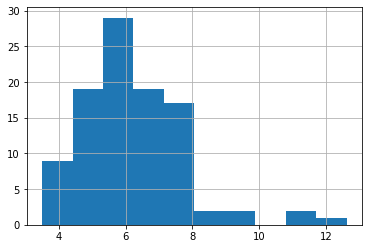

In [12]:
pd.Series(scores).hist()

In [13]:
print('extreme', ' - ', (1 + (pd.Series(scores) > 70.0358).sum())/101)

extreme  -  0.009900990099009901


In [15]:
pd.DataFrame([[sub, sc] for sub, sc in zip(subsets, scores)]).to_csv('../results/compas_power.csv', index = False)